# Creating Dataframe of Outcome and Feature Variables

In [13]:
from statistics import median
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib as mpl

feature_list_xlsx = ["CZA","CZH","CZV","TRF"]
feature_list_csv = ["EDU","MHI","perc_below_poverty", "perc_rental_housing","unemployment"]
feature_list = feature_list_csv + feature_list_xlsx
path = os.path.join(os.getcwd(),'data_clean')
feature_values = pd.read_excel(os.path.join(path,'TRF_2016.xlsx'))
geoid = feature_values['GEOID']
dataframes = {}

# Read in feature values
for year in range(2016, 2020):
    df_dict = {}
    df_dict['GEOID'] = geoid
    df_dict['YEAR'] = year
    for feature in feature_list_xlsx:
        file_name = feature + "_" + str(year) + '.xlsx'
        feature_values = pd.read_excel(os.path.join(path,file_name))
        df_dict[feature] = feature_values[file_name[:-5]]
    for feature in feature_list_csv:
        file_name = feature + "_" + str(year) + '.csv'
        feature_values = pd.read_csv(os.path.join(path,file_name))
        df_dict[feature] = feature_values[file_name[:-4]]
    dataframes[year] = pd.DataFrame(df_dict)

feature_values = pd.concat(dataframes.values(), ignore_index=True)
feature_values = feature_values.apply(pd.to_numeric, errors='coerce')

# Replace missing feature values with column averages (median) # CHECK IF WE SHOULD MOVE THIS TO AFTER THE SPLIT
for feature in feature_list:
    col_ave = feature_values[feature].median()
    feature_values[feature].fillna(value = col_ave, inplace = True)

# Read in house values
house_values = pd.read_csv(os.path.join(path,'home_value.csv'))
renamed_geoid = []
for row in house_values['GEOID']:
    tract_num = (row.split(',')[0]).replace("Census Tract ",'')
    if ('.' in tract_num):
        tract_num = '17031' + tract_num.replace('.','')
    else:
        tract_num = '17031' + tract_num + '00'
    renamed_geoid.append(int(tract_num))
house_values['GEOID'] = renamed_geoid

# Create dataframe of feature and outcome values
df = pd.merge(house_values, feature_values, on=['YEAR','GEOID'])
print(df)

            GEOID  YEAR  house_value   CZA  CZH   CZV          TRF   EDU  \
0     17031100100  2016       267200   5.0  0.0  10.0   605.408171  29.3   
1     17031100200  2016       280300   5.0  0.0   9.0   152.776736  34.8   
2     17031100300  2016       339600   6.0  0.0   6.0  1223.176635  26.8   
3     17031100400  2016       327700   0.0  0.0   0.0  1865.990705  17.9   
4     17031100500  2016       317200   1.0  0.0   4.0  1962.186822  27.5   
...           ...   ...          ...   ...  ...   ...          ...   ...   
2552  17031843500  2019       178700  18.0  0.0  19.0    59.800037  19.7   
2553  17031843600  2019       266500   4.0  1.0  38.0   117.703178  27.3   
2554  17031843700  2019       499700   9.0  0.0   8.0  1446.135953  17.6   
2555  17031843800  2019       171900  47.0  0.0  13.0   358.570786  12.6   
2556  17031843900  2019       105700   9.0  0.0  83.0   678.758602  16.9   

          MHI  perc_below_poverty  perc_rental_housing  unemployment  
0     63058.0   

# Summary Statistics

In [10]:
# feature_list = ["CZV", "TRF"] # remove this later
# outcome_feature_list = ['house_value'] + feature_list
# df = df.loc[:,outcome_feature_list]

df = df.drop('GEOID',1)
df['YEAR'], _ = pd.factorize(df['YEAR'], sort=True)
print(df.head())
print(df.describe())
print(df.dtypes)

   YEAR  house_value  CZA  CZH   CZV          TRF   EDU  MHI  \
0     0       267200  5.0  0.0  10.0   605.408171  29.3  NaN   
1     0       280300  5.0  0.0   9.0   152.776736  34.8  NaN   
2     0       339600  6.0  0.0   6.0  1223.176635  26.8  NaN   
3     0       327700  0.0  0.0   0.0  1865.990705  17.9  NaN   
4     0       317200  1.0  0.0   4.0  1962.186822  27.5  NaN   

   perc_below_poverty  perc_rental_housing  unemployment  
0                 9.5             0.329078          10.6  
1                 5.5             0.293510           5.1  
2                 8.5             0.316569           5.0  
3                 4.4             0.040783           6.0  
4                 3.8             0.107461           0.5  
              YEAR    house_value          CZA          CZH          CZV  \
count  2557.000000    2557.000000  2557.000000  2557.000000  2557.000000   
mean      1.497067  226160.344153    19.554947     0.935862    36.908878   
std       1.118424  116980.171833

/home/hemmerly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [11]:
print(df.dtypes)

YEAR                     int64
house_value              int64
CZA                    float64
CZH                    float64
CZV                    float64
TRF                    float64
EDU                    float64
MHI                    float64
perc_below_poverty     float64
perc_rental_housing    float64
unemployment           float64
dtype: object


The dataframe comprises 2557 observations, where each observation contains the median house value (outcome variable) and x feature variables for a given census tract and year.

Observations with missing outcome variables were dropped from the dataframe, while missing feature values were replaced with the median value for that feature in that year.

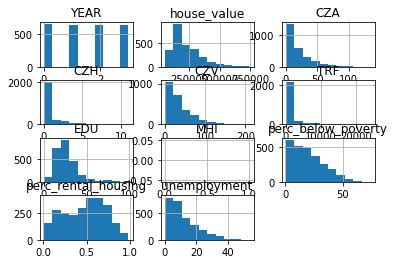

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist()
plt.show()

From plotting the distribution of the feature values,  we observe that features vary significantly in scale. 
Features including CZV and TRF skew right.

In [109]:
corr_matrix = df.corr()
corr_matrix["house_value"].sort_values(ascending=False)

house_value            1.000000
EDU                    0.339656
TRF                    0.280788
YEAR                   0.101193
perc_rental_housing   -0.097496
CZH                   -0.311610
CZV                   -0.343267
CZA                   -0.395349
perc_below_poverty    -0.438816
unemployment          -0.549308
MHI                         NaN
Name: house_value, dtype: float64

Add analysis on correlation between feature variables and outcome variable.

# Feature Engineering

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X = df.drop('house_value', 1)
y = df['house_value']

imputer = SimpleImputer(strategy="median")

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
X_trans = (num_pipeline.fit_transform(X))

train_x, test_x, train_y, test_y = train_test_split(X_trans, y.to_numpy(), test_size=0.2, random_state=123)

# appending biases
train_x = np.concatenate((np.ones((train_x.shape[0], 1)), train_x), axis=1)
test_x = np.concatenate((np.ones((test_x.shape[0], 1)), test_x), axis=1)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
